## This notebook aims to visualize the different asset distributions produced by CGAN

Testing BondGANS

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler


!pip install python-dotenv

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [3]:
from drive.MyDrive.MasterThesis.FashionGANOLD import ForcastGAN
from drive.MyDrive.MasterThesis.FashionGAN import FashionGAN
from drive.MyDrive.MasterThesis.BondGAN2 import BondGAN
from drive.MyDrive.MasterThesis.lambardGAN import LambardGAN
from drive.MyDrive.MasterThesis.simple_gan_portfolio import SimpleGANPortfolio
from drive.MyDrive.MasterThesis.gan_plotting import extensive_plotting

from drive.MyDrive.MasterThesis.shortrateGAN import shortRateGAN
from drive.MyDrive.MasterThesis.lambardGAN import LambardGAN

### Parameters

In [4]:
assets_0 = 1000000
liabilities_0 = 1000000 * 0.88
num_simulations = 10000
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [5]:
'''
def fetch_data_df():
    # Load the data
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = '2020-01-01'

    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [1,2]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:]

    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

'''

def fetch_data_df():
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)

    reference_start_test_date = pd.to_datetime('2020-01-01')
    selected_columns_indices = [3]

    data_subset = df.iloc[:, selected_columns_indices]

    if not data_subset.index.is_monotonic_increasing:
        data_subset = data_subset.sort_index()

    ref_idx_position = data_subset.index.searchsorted(reference_start_test_date)

    actual_split_idx_position = max(0, ref_idx_position - 252)

    actual_split_date = data_subset.index[actual_split_idx_position]

    pre_test_df = data_subset[data_subset.index < actual_split_date]
    test_df = data_subset[data_subset.index >= actual_split_date]

    return pre_test_df, test_df


returns_df, test_returns_df = fetch_data_df()

In [6]:
asset_names = returns_df.columns

gan_dict = {}

In [7]:
test_returns_df.head()

,IG
Date,
2019-01-03,0.003209
2019-01-04,-0.004488
2019-01-07,0.000024
2019-01-08,-0.000592
2019-01-09,0.001019


In [8]:
import pickle

save_dir = '/content/drive/MyDrive/gan_models_1'
scenarios_dir = '/content/drive/MyDrive/gan_scenarios'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(scenarios_dir, exist_ok=True)




Training GANs:   0%|          | 0/1 [00:00<?, ?asset/s]

Training GAN for IG...


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training: [████████████████████] 100.0% | Epoch 3000/3000 | Batch 2/2 | D: -5.2099 | G: 0.0000 | Tail: 0.0000


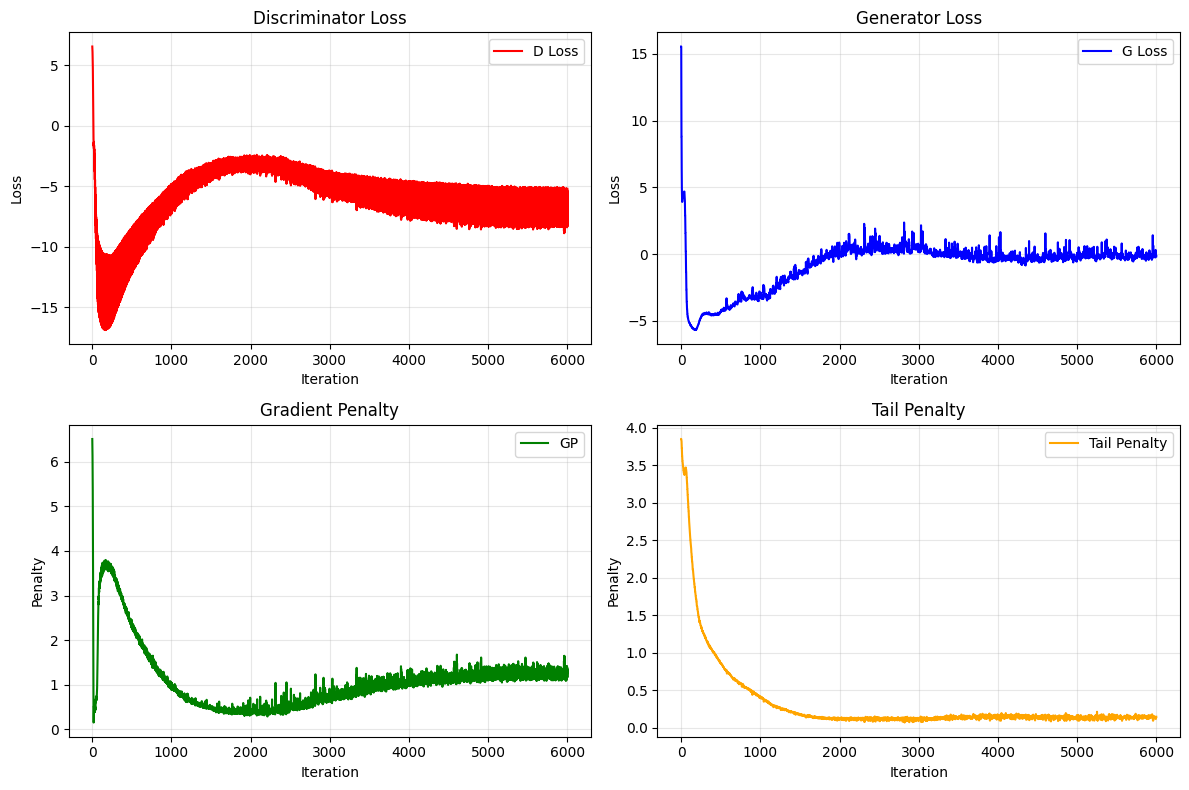

Training GANs: 100%|██████████| 1/1 [01:57<00:00, 117.25s/asset]

Finished training GAN for IG.

Generated scenarios saved to: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt
Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-01-02 00:00:00.


In [9]:
# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]

    if asset_name in ['IG', 'HY', 'GOV']:
          #gan = BondGAN(asset_returns, asset_name, n_epochs=3000, lambda_gp =7, cond_scale=0.005)
          #gan.g_lr = 10e-6
          #gan.d_lr = 50e-8
          gan = BondGAN(asset_returns, asset_name, n_epochs=3000, lambda_gp =7, lag_periods=[14,90,180], cond_scale=0.01025, lambda_skew = 50)
          gan.g_lr = 10e-6
          gan.d_lr = 50e-8

    elif asset_name == 'EONIA':
        gan = shortRateGAN(asset_returns, asset_name, n_epochs=1200, lambda_gp = 7, cond_scale=0.2)
        gan.g_lr = 10e-7
        gan.d_lr = 50e-8
    else:
        #        gan = LambardGAN(asset_returns, asset_name, n_epochs=10000,
                         #lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.6)
        gan = LambardGAN(asset_returns, asset_name, n_epochs=6000,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.25)
        gan.g_lr = 10e-6
        gan.d_lr = 10e-7

    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")

    scenarios = gan.generate_scenarios(num_scenarios=4000)
    print(f"Finished generating scenarios for {asset_name}.\n")

    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    next_day = initial_date + pd.Timedelta(days=1)
    scenarios_results.setdefault(asset_name, {})[next_day] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

In [11]:
df = pd.DataFrame({'d_losses': gan.d_losses})
df.to_csv('/content/drive/MyDrive/MasterThesis/d_losses/ig.csv', index=False)

print("Saved to /content/drive/MyDrive/MasterThesis/d_losses/ig.csv")

Saved to /content/drive/MyDrive/MasterThesis/d_losses/ig.csv


In [10]:
def load_gan_model(asset_name, model_class, num):
    model_path = f"/content/drive/MyDrive/gan_models_{num}/{asset_name}_gan.pt"
    checkpoint = torch.load(model_path, weights_only=False)

    dummy_returns = returns_df[asset_name]

    if asset_name in ['IG', 'HY', 'GOV']:
        gan = model_class(dummy_returns, asset_name, n_epochs=1000, lambda_gp =7, cond_scale=1)
        gan.g_lr = 10e-6
        gan.d_lr = 50e-8

    elif asset_name == 'EONIA':
        gan = model_class(dummy_returns, asset_name, n_epochs=1200, lambda_gp = 7, cond_scale=1)
        gan.g_lr = 10e-7
        gan.d_lr = 50e-8
    else:
        gan = model_class(dummy_returns, asset_name, n_epochs=3000,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.35)
        gan.g_lr = 10e-6
        gan.d_lr = 10e-7

    gan.setup()

    # Load saved weights and scalers
    gan.generator.load_state_dict(checkpoint['generator'])
    gan.generator.eval()
    gan.discriminator.load_state_dict(checkpoint['discriminator'])
    gan.discriminator.eval()
    #gan.scaler = checkpoint['scaler']
    #gan.condition_scaler = checkpoint['condition_scaler']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    gan.generator.to(device)
    gan.discriminator.to(device)
    gan.cuda = torch.cuda.is_available()

    return gan



'''
for asset_name in returns_df.columns:
    print(asset_name)
    if asset_name in ['IG', 'HY', 'GOV']:
        gan_dict[asset_name] = load_gan_model(asset_name, BondGAN, 2)
    elif asset_name == 'EONIA':
        gan_dict[asset_name] = load_gan_model(asset_name, shortRateGAN, 2)
    else:
      continue
      gan_dict[asset_name] = load_gan_model(asset_name, LambardGAN, 1)

'''



"\nfor asset_name in returns_df.columns:\n    print(asset_name)\n    if asset_name in ['IG', 'HY', 'GOV']:\n        gan_dict[asset_name] = load_gan_model(asset_name, BondGAN, 2)\n    elif asset_name == 'EONIA':\n        gan_dict[asset_name] = load_gan_model(asset_name, shortRateGAN, 2)\n    else:\n      continue\n      gan_dict[asset_name] = load_gan_model(asset_name, LambardGAN, 1)\n\n"

In [ ]:
# Prelimenary  For reseting

for asset_name in gan_dict:
    gan_dict[asset_name].returns_series = returns_df[asset_name]

In [ ]:
all_dates = []

for asset_name in test_returns_df.columns:
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    print("Asset =", asset_name)

    i = 0
    for test_day in tqdm(test_returns_df.index[:-252], desc="Processing Dates", unit="dates"):
        i += 1
        new_return = test_returns_df.loc[test_day, asset_name]

        if test_day != test_returns_df.index[-1]:
            next_day = test_returns_df.index[test_returns_df.index.get_loc(test_day) + 1]
        else:
            print(f"Warning: {test_day} is the last day in the index, no next day available.")
            continue

        #if i % 252 == 0:
          # Retrain
         # gan.prep_retrain(new_return, test_day)
          #print()
         # gan.train()

        # test different lookbacks
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, 1, next_day, save=True, num_scenarios=10000)

        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break
        all_dates.append(next_day)

    if foundNAN: break

Asset = IG


Processing Dates: 100%|██████████| 1232/1232 [00:55<00:00, 22.34dates/s]


## Making sure the window ends when we want to start testing

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

'''
test_start_date = '2020-01-01'
test_start_date = pd.to_datetime(test_start_date)

test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
'''

# Slice 252 rows before that index
historical_df = test_returns_df
historical_df.head()

,IG
Date,
2019-01-03,0.003209
2019-01-04,-0.004488
2019-01-07,0.000024
2019-01-08,-0.000592
2019-01-09,0.001019


In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

In [ ]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]

    # Get returns and EONIA for this window
    window_returns = (window_data).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]

    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return

    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()

    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0

    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values_1.append(portfolio_value_end)

## Does not work, since when we have a rolling BOF_0, and windows are overlapping, returns are counted over again multiple times, hence blowing up bof_0

To mitigate these i look at portfolio and liability values on a daily basis. I check the start and end values for all the different windows.

In [ ]:
import concurrent.futures
from functools import partial
from tqdm import tqdm


def process_date(date, asset_names, device="cuda"):
    gan_samples_cols = []
    for asset in asset_names:
        file_path = os.path.join(f"test_{date}", f"generated_returns_{asset}_scenarios.pt")
        asset_scenarios = torch.load(file_path, map_location=device).double()
        asset_cum = torch.prod(1 + asset_scenarios, dim=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    gan_samples = torch.cat(gan_samples_cols, dim=1)


    # Calculate VaR
    cumulative_returns = torch.prod(1 + gan_samples, dim=1) - 1  # Shape: (N,)

    final_asset_values = assets_0 * (1 + cumulative_returns)

    var = torch.quantile(final_asset_values, 0.005)




    if var > 1e6:
        var = 1e6


    return date, var


asset_names = list(returns_df.columns)
all_dates = set(all_dates)
all_dates = sorted(all_dates)

portfolio_scr_results = {}
for date in tqdm(all_dates, desc="Processing dates with GPU"):
    date, scr = process_date(date, asset_names=asset_names)
    portfolio_scr_results[date] = scr

Processing dates with GPU:   0%|          | 0/1232 [00:00<?, ?it/s]<ipython-input-15-5802bf869ab6>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  asset_scenarios = torch.

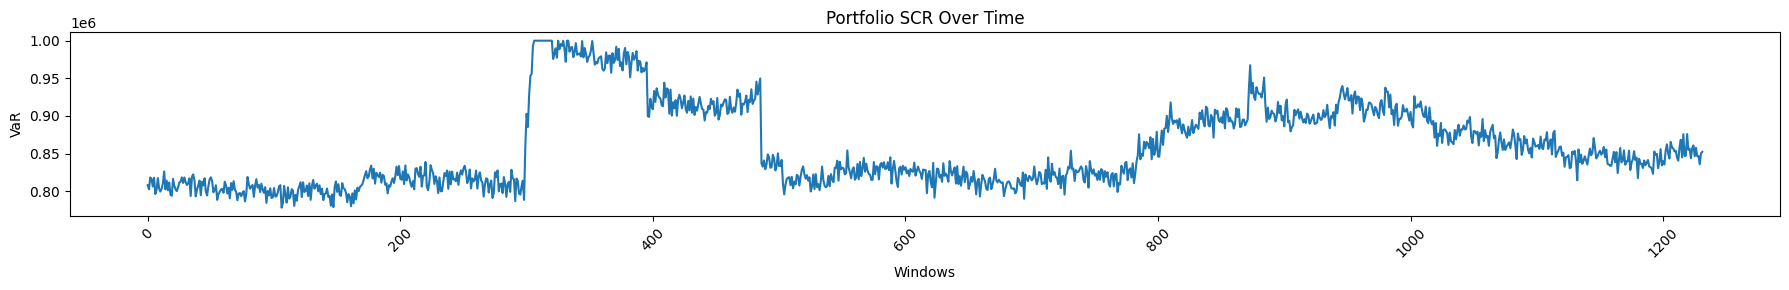

In [ ]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date].cpu() if hasattr(portfolio_scr_results[date], 'cpu') else portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("VaR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
1232/200

6.16

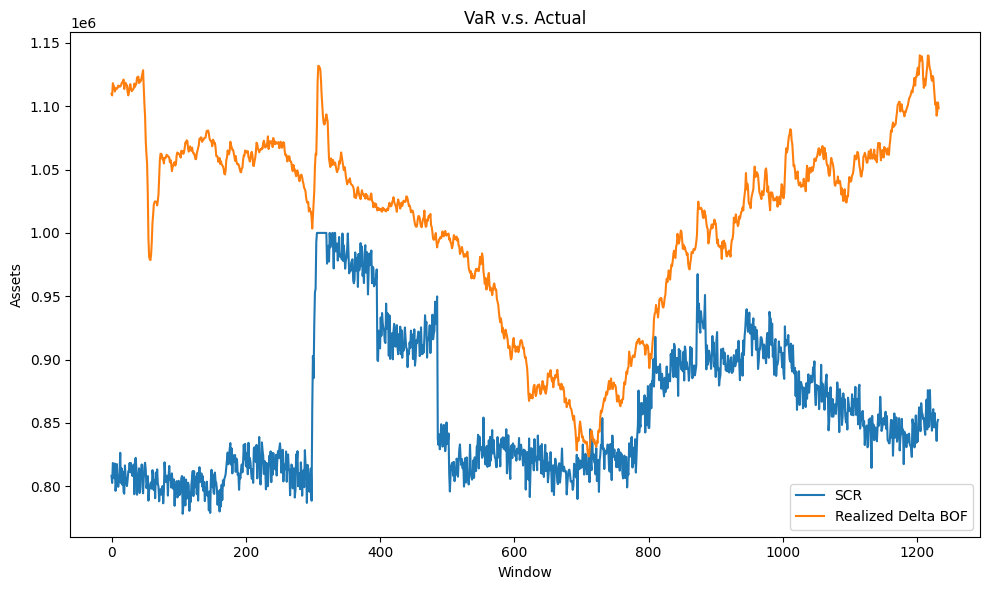

SCR exceeds realized: 2.0 times out of 1232
Window = 712
Window = 714


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')


plt.xlabel("Window")
plt.ylabel("Assets")
plt.title("VaR v.s. Actual")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

exceedances = sum(scr > realized for scr, realized in zip(scr_values, realized_delta_bof_values_1))
print(f"SCR exceeds realized: {exceedances} times out of {len(scr_values)}")

count = 0
for i in range(len(scr_values)):

    if scr_values[i] > realized_delta_bof_values_1[i]:
      count += 1
      print("Window =", i+ 1)

In [ ]:
save_dir = '/content/drive/MyDrive/gan_models_1'
scenarios_dir = '/content/drive/MyDrive/gan_scenarios'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(scenarios_dir, exist_ok=True)

"""
# Save GAN models
for asset_name, gan in gan_dict.items():
    model_path = f"{save_dir}/{asset_name}_gan.pt"
    torch.save({
        'generator': gan.generator.state_dict(),
        'discriminator': gan.discriminator.state_dict(),
        'scaler': gan.scaler,
        'condition_scaler': gan.condition_scaler
    }, model_path)

print(f"Saved {len(gan_dict)} models to {save_dir}")
"""


Saved 1 models to /content/drive/MyDrive/gan_models_1


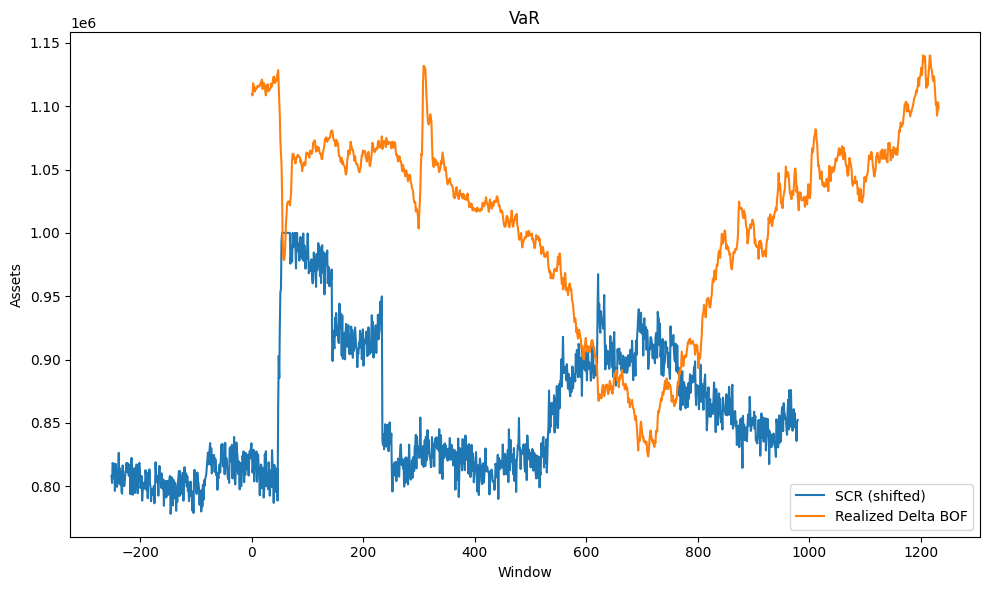

In [ ]:
x_scr_shifted = range(-252, len(scr_values) - 252)
plt.figure(figsize=(10, 6))
plt.plot(x_scr_shifted, scr_values, linestyle='-', label='SCR (shifted)')

# Plot realized_delta_bof_values_1 (assuming its x-values start from 0)
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

plt.xlabel("Window")
plt.ylabel("Assets")
plt.title("VaR")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## SHOWING A BUNCH OF GAN SPESIFIC RESULTS

- Distributions
- Latent space plots
- PCAs

etc.

In [ ]:
for asset_name in returns_df.columns:
    print(asset_name)
    if asset_name in ['IG', 'HY', 'EONIA']:
        gan_dict[asset_name].generate_scenarios(num_scenarios=4000)
    else:
      gan_dict[asset_name].generate_scenarios(num_scenarios=4000)

IG
Generated scenarios saved to: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt


# ----------------------------------------------------------

Loaded Generated returns from: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt


/content/drive/MyDrive/MasterThesis/gan_plotting.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_returns = torch.load(file_path)


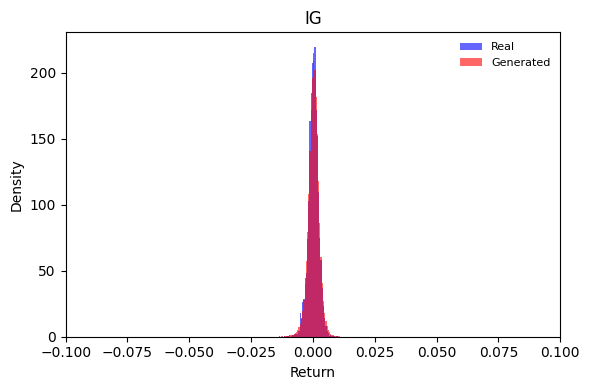


📊 Return Statistics Summary:
         Asset     Mean  Std Dev  Skewness  Kurtosis      Max       Min  99.5% VaR
     IG - Real 0.000175 0.002120 -0.459110  2.182689 0.009733 -0.013433  -0.006950
IG - Generated 0.000299 0.002262 -0.618357 10.118206 0.017364 -0.080973  -0.007198



═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000005
✅ Generated Data Shows Reasonable Variance


/content/drive/MyDrive/MasterThesis/gan_plotting.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_returns = torch.load(file_path)


Mean Pairwise Distance (Real): 0.046857
Mean Pairwise Distance (Generated): 0.048408
✅ Generated samples are reasonably diverse


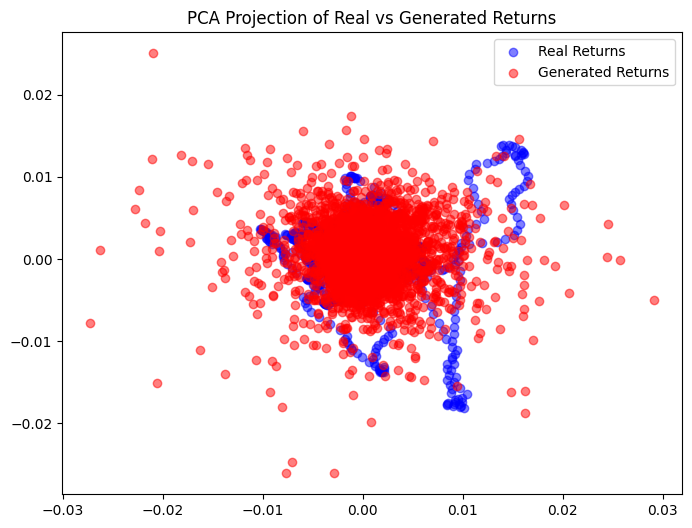

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


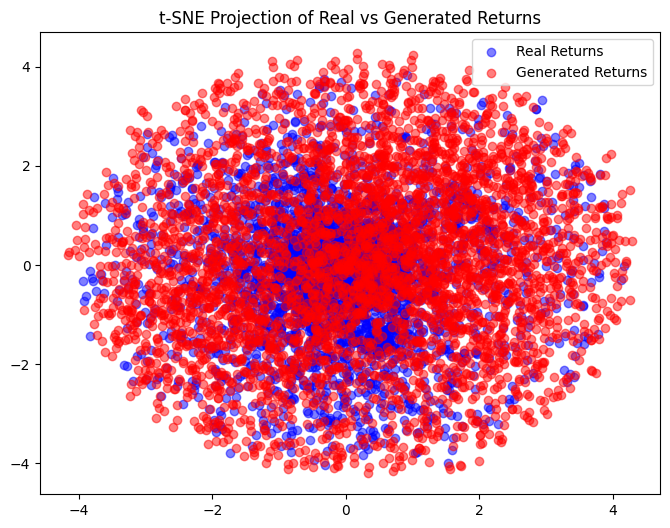

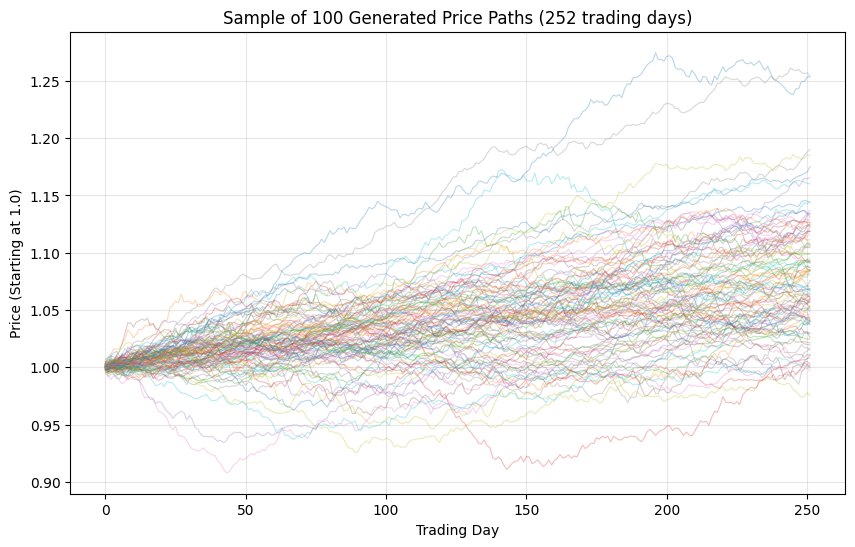

Loaded Generated returns from: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt


/content/drive/MyDrive/MasterThesis/gan_plotting.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_returns = torch.load(file_path)


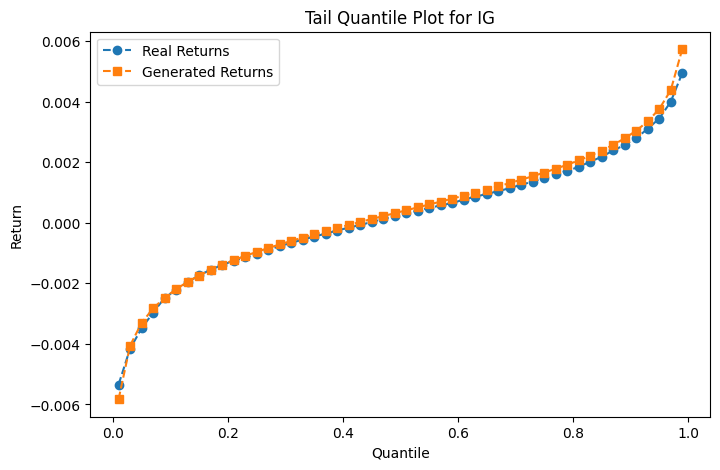


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 29.792721
Mean Distance: 0.002242
Median Distance: 0.000382
Standard Deviation: 0.071342


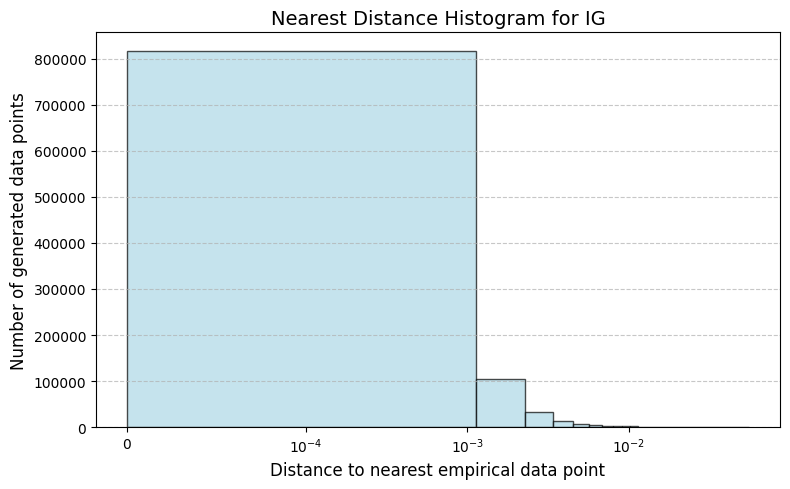


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test/generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000141



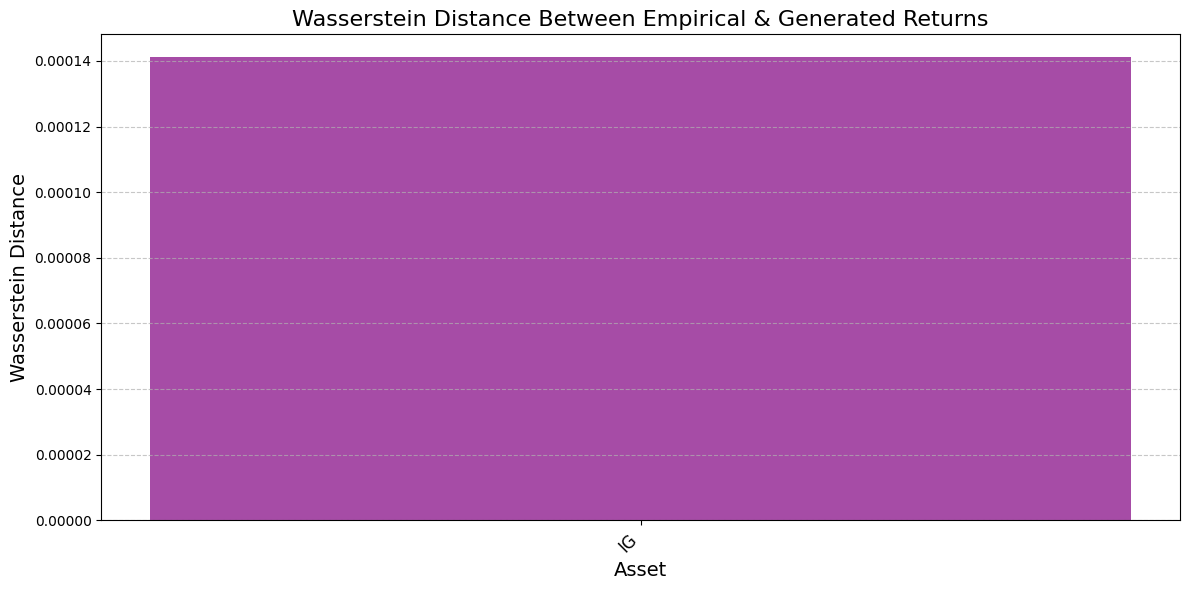

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)


**Component 0** (1.1% variance)

**Component 1** (1.0% variance)

**Component 2** (1.0% variance)


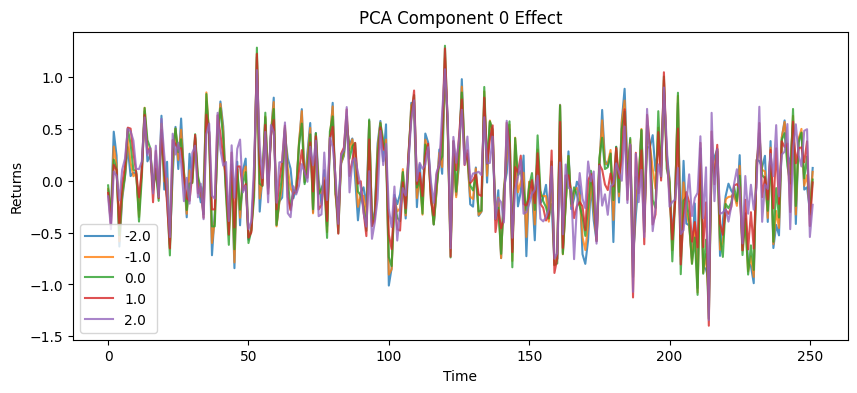

In [ ]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def explain_gan_latent(gan, n_samples=2000):
    """Explain GAN using PCA on latent space"""
    device = 'cuda' if gan.cuda else 'cpu'
    gan.generator.eval()

    with torch.no_grad():
        # Sample latent + conditions
        z = torch.randn(n_samples, gan.latent_dim, device=device)
        cond_idx = np.random.choice(len(gan.conditions), n_samples, replace=True)
        cond = torch.tensor(gan.conditions[cond_idx], dtype=torch.float32, device=device)

        # Generate scenarios
        gen = gan.generator(z, cond).cpu().numpy()
        z_np = z.cpu().numpy()
        cond_np = cond.cpu().numpy()

    # PCA on latent space
    pca = PCA(n_components=5)
    z_pca = pca.fit_transform(z_np)

    # Compute scenario statistics
    stats = {
        'mean': np.mean(gen, axis=1),
        'std': np.std(gen, axis=1),
        'min': np.min(gen, axis=1),
        'skew': [np.mean((g - np.mean(g))**3) / np.std(g)**3 for g in gen]
    }

    # Correlations: PCA components vs output stats & conditions
    results = []
    for i in range(5):
        corr = {
            'component': i,
            'variance_explained': pca.explained_variance_ratio_[i],
            'mean_return': np.corrcoef(z_pca[:, i], stats['mean'])[0,1],
            'volatility': np.corrcoef(z_pca[:, i], stats['std'])[0,1],
            'tail_risk': np.corrcoef(z_pca[:, i], stats['min'])[0,1],
            'skewness': np.corrcoef(z_pca[:, i], stats['skew'])[0,1]
        }

        # Correlations with market conditions (your lag features)
        cond_corrs = [np.corrcoef(z_pca[:, i], cond_np[:, j])[0,1]
                     for j in range(cond_np.shape[1])]
        corr['condition_correlations'] = cond_corrs
        results.append(corr)

    return results, pca, z_np, gen, cond_np

def plot_latent_effects(gan, pca, component=0):
    """Show how latent component affects scenarios"""
    device = 'cuda' if gan.cuda else 'cpu'

    # Fixed condition + vary latent component
    base_z = torch.zeros(1, gan.latent_dim, device=device)
    fixed_cond = torch.tensor(gan.conditions[0:1], dtype=torch.float32, device=device)

    variations = np.linspace(-2, 2, 5)
    scenarios = []

    with torch.no_grad():
        for v in variations:
            z_var = base_z.clone()
            z_var += torch.tensor(pca.components_[component] * v, dtype=torch.float32, device=device)
            gen = gan.generator(z_var, fixed_cond).cpu().numpy()[0]
            scenarios.append(gen)

    # Plot
    plt.figure(figsize=(10, 4))
    for i, scenario in enumerate(scenarios):
        plt.plot(scenario, alpha=0.8, label=f'{variations[i]:.1f}')
    plt.title(f'PCA Component {component} Effect')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

def print_interpretation(results):
    """Print key findings"""
    condition_names = ['cum_ret_14d', 'vol_14d', 'kurt_14d', 'drawdown_14d',
                      'cum_ret_90d', 'vol_90d', 'kurt_90d', 'drawdown_90d',
                      'cum_ret_180d', 'vol_180d', 'kurt_180d', 'drawdown_180d']

    for r in results[:3]:  # Top 3 components
        print(f"\n**Component {r['component']}** ({r['variance_explained']:.1%} variance)")

        # Output effects
        if abs(r['mean_return']) > 0.2:
            print(f"  Return level: {r['mean_return']:.2f}")
        if abs(r['volatility']) > 0.2:
            print(f"  Volatility: {r['volatility']:.2f}")
        if abs(r['tail_risk']) > 0.2:
            print(f"  Tail risk: {r['tail_risk']:.2f}")

        # Condition effects
        top_cond = np.argsort(np.abs(r['condition_correlations']))[-2:]
        for idx in top_cond:
            if abs(r['condition_correlations'][idx]) > 0.15:
                print(f"  {condition_names[idx]}: {r['condition_correlations'][idx]:.2f}")

# Usage:
def analyze_gan(gan):
    results, pca, z, gen, cond = explain_gan_latent(gan)
    print_interpretation(results)
    plot_latent_effects(gan, pca, 0)  # Plot top component
    return results, pca


for name in gan_dict:
    results, pca = analyze_gan(gan_dict[name])